# Importing libraries

In [43]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [44]:
df = yf.download('AAPL', start='2010-01-01', end='2024-01-01')
df.columns = df.columns.droplevel(1) 
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,6.440331,6.455077,6.391278,6.422877,493729600
2010-01-05,6.451465,6.487878,6.417459,6.458086,601904800
2010-01-06,6.348845,6.477044,6.342224,6.451464,552160000
2010-01-07,6.337111,6.379844,6.291068,6.372321,477131200
2010-01-08,6.379241,6.379843,6.291368,6.328683,447610800


Price,Close,High,Low,Open,Volume
count,3522.000000,3522.000000,3522.000000,3522.000000,3.522000e+03
mean,57.574681,58.154507,56.940304,57.532586,2.422834e+08
std,55.520111,56.088908,54.889500,55.463714,2.204578e+08
min,5.779476,5.898345,5.725308,5.789107,2.404830e+07
25%,16.948886,17.103420,16.785683,16.966756,9.266760e+07
50%,29.039499,29.255417,28.786081,29.039403,1.526602e+08
75%,88.776247,90.046480,88.015214,88.781739,3.284715e+08
max,196.927658,198.428641,195.824279,196.838199,1.880998e+09


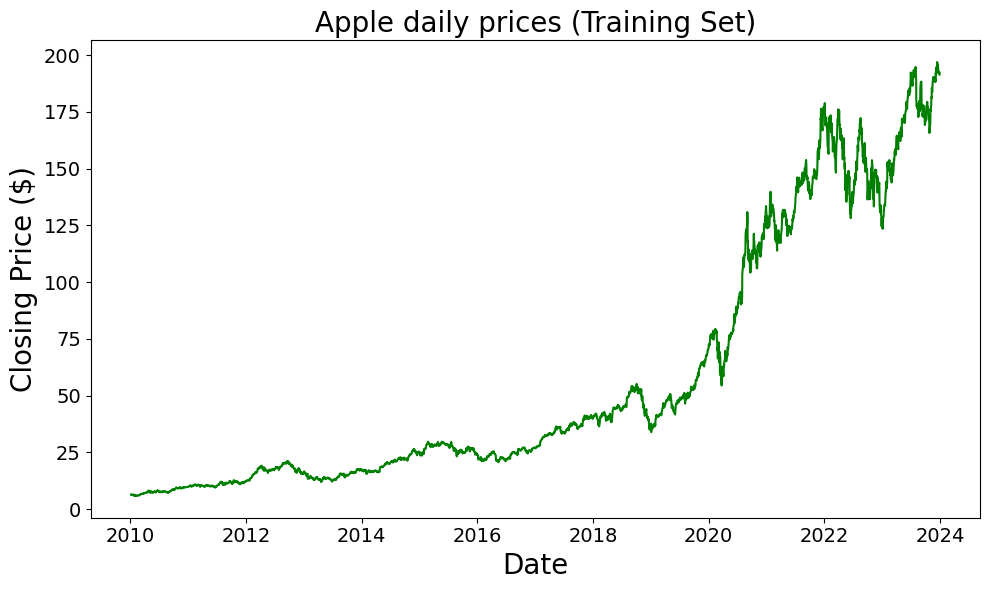

In [45]:
plt.figure(figsize=(10,6))
plt.plot(
  df.index,
  df['Close'],
  #label="Close Price ($)",
  color="green"
)
#plt.legend(fontsize=18, loc="upper left")
plt.yticks(fontsize=14)
plt.xlabel("Date", fontsize=20)
plt.xticks(fontsize=14)
plt.ylabel("Closing Price ($)", fontsize=20)
plt.title("Apple daily prices (Training Set)", fontsize=20)
plt.tight_layout()
df.describe()

# Scaling and Train/Test split

In [46]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X = df['Close'].values.reshape(-1, 1)

X = scaler.fit_transform(X)

train_size = int(len(X) * 0.8)
train_data = X[:train_size]
test_data = X[train_size:]

## Preparing data

In [48]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append((seq, label))
    return sequences

seq_length = 10 # Number of days to base prediction on
train_sequences = create_sequences(train_data, seq_length)
test_sequences = create_sequences(test_data, seq_length)
train_sequences[:5]

[(array([[-0.99308541],
         [-0.99296892],
         [-0.99404264],
         [-0.99416541],
         [-0.99372461],
         [-0.99431341],
         [-0.99506597],
         [-0.9941434 ],
         [-0.99452751],
         [-0.99562958]]),
  array([-0.99276109])),
 (array([[-0.99296892],
         [-0.99404264],
         [-0.99416541],
         [-0.99372461],
         [-0.99431341],
         [-0.99506597],
         [-0.9941434 ],
         [-0.99452751],
         [-0.99562958],
         [-0.99276109]]),
  array([-0.99380332])),
 (array([[-0.99404264],
         [-0.99416541],
         [-0.99372461],
         [-0.99431341],
         [-0.99506597],
         [-0.9941434 ],
         [-0.99452751],
         [-0.99562958],
         [-0.99276109],
         [-0.99380332]]),
  array([-0.99495576])),
 (array([[-0.99416541],
         [-0.99372461],
         [-0.99431341],
         [-0.99506597],
         [-0.9941434 ],
         [-0.99452751],
         [-0.99562958],
         [-0.99276109],
       

## Building the LSTM model

In [49]:
class LSTM_Network(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, dropout=0.2):
        super(LSTM_Network, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.fc(lstm_out[:, -1])
        return predictions

## Converting data to Tensors

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM_Network().to(device)

# Convert train_sequences to np array for optimizating Tensor creation
train_features = torch.tensor(np.array([s[0] for s in train_sequences]), dtype=torch.float32).to(device) 
train_labels = torch.tensor(np.array([s[1] for s in train_sequences]), dtype=torch.float32).unsqueeze(1).to(device)


criterion = nn.MSELoss() # We'll use Mean Squared Error as our loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # And Adam as our optimizer

## Training the model

In [51]:
epochs = 1000
def train(model, train_features, train_labels, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = model(train_features)
        loss = criterion(predictions, train_labels)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch} loss: {loss.item()}')
        
train(model, train_features, train_labels, epochs)

/home/martin/projects/Geometric_DataAnalysis/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([2807, 1, 1])) that is different to the input size (torch.Size([2807, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 loss: 0.7005733847618103
Epoch 10 loss: 0.4119972288608551
Epoch 20 loss: 0.08421920239925385
Epoch 30 loss: 0.08343120664358139
Epoch 40 loss: 0.0910148173570633
Epoch 50 loss: 0.08504269272089005
Epoch 60 loss: 0.0825629010796547
Epoch 70 loss: 0.0825301855802536
Epoch 80 loss: 0.08242747187614441
Epoch 90 loss: 0.08222714066505432
Epoch 100 loss: 0.08206909894943237
Epoch 110 loss: 0.08200722187757492
Epoch 120 loss: 0.08191986382007599
Epoch 130 loss: 0.08186378329992294
Epoch 140 loss: 0.08180727809667587
Epoch 150 loss: 0.08174924552440643
Epoch 160 loss: 0.08171095699071884
Epoch 170 loss: 0.08167506009340286
Epoch 180 loss: 0.08162000775337219
Epoch 190 loss: 0.08161396533250809
Epoch 200 loss: 0.0815839096903801
Epoch 210 loss: 0.08156292140483856
Epoch 220 loss: 0.08152566105127335
Epoch 230 loss: 0.08152696490287781
Epoch 240 loss: 0.08152011781930923
Epoch 250 loss: 0.08151181042194366
Epoch 260 loss: 0.08150181919336319
Epoch 270 loss: 0.08149111270904541
Epoch 280

## Evaluating model

In [52]:
model.eval()
with torch.no_grad():
    test_features = torch.tensor(np.array([s[0] for s in test_sequences]), dtype=torch.float32).to(device)
    #test_labels = torch.tensor(np.array([s[1] for s in test_sequences]), dtype=torch.float32).unsqueeze(1).to(device)
    test_predictions = model(test_features).cpu().numpy()

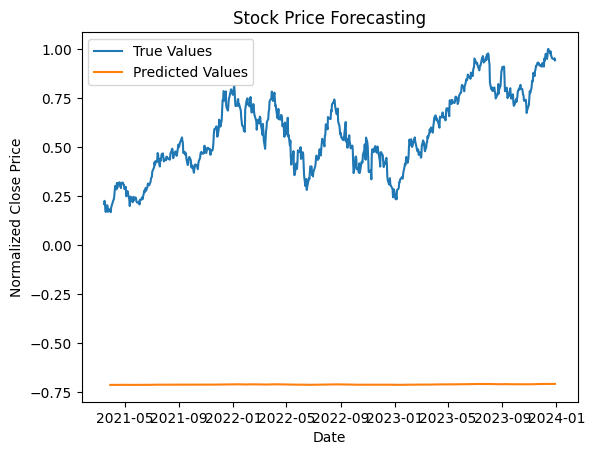

In [53]:
dates = df.index.values
plt.plot(dates[train_size:len(X)], test_data, label='True Values')
plt.plot(dates[train_size+seq_length:len(X)], test_predictions, label='Predicted Values')
plt.xlabel('Date')
plt.ylabel('Normalized Close Price')
plt.title('Stock Price Forecasting')
plt.legend()
plt.show()

In [54]:
df[train_size:len(X)]

Price,Close,High,Low,Open,Volume
Date,,,,,
2021-03-15,121.292046,121.301830,117.799727,118.768191,92403800
2021-03-16,122.837692,124.451791,122.006189,122.964861,115227900
2021-03-17,122.045288,123.121351,119.677940,121.350738,111932600
2021-03-18,117.907349,120.499688,117.701919,120.206213,121229700
2021-03-19,117.379105,118.787774,117.075852,117.291067,185549500
...,...,...,...,...,...
2023-12-22,192.444595,194.243791,191.818350,194.015153,37122800
2023-12-26,191.897873,192.732856,191.679185,192.454528,28919300
2023-12-27,191.997253,192.345171,189.949550,191.341204,48087700


In [55]:
test_predictions

array([[-0.7145809 ],
       [-0.7145828 ],
       [-0.71459335],
       [-0.71461153],
       [-0.7145929 ],
       [-0.7145548 ],
       [-0.7145121 ],
       [-0.7144732 ],
       [-0.71441996],
       [-0.7143537 ],
       [-0.714289  ],
       [-0.7142484 ],
       [-0.71419704],
       [-0.7141726 ],
       [-0.71413535],
       [-0.71410835],
       [-0.7140831 ],
       [-0.71407723],
       [-0.7140816 ],
       [-0.7140977 ],
       [-0.7140779 ],
       [-0.7140635 ],
       [-0.71404755],
       [-0.7140541 ],
       [-0.7140704 ],
       [-0.71410304],
       [-0.71412945],
       [-0.7141875 ],
       [-0.7142199 ],
       [-0.7142272 ],
       [-0.7142305 ],
       [-0.7142652 ],
       [-0.71431637],
       [-0.7143817 ],
       [-0.71440095],
       [-0.7143945 ],
       [-0.7143818 ],
       [-0.7143893 ],
       [-0.7144029 ],
       [-0.7144053 ],
       [-0.7144083 ],
       [-0.71439886],
       [-0.71437836],
       [-0.71437347],
       [-0.71439755],
       [-0

In [56]:
test_features

tensor([[[0.2086],
         [0.2248],
         [0.2165],
         ...,
         [0.1687],
         [0.1738],
         [0.1802]],

        [[0.2248],
         [0.2165],
         [0.1732],
         ...,
         [0.1738],
         [0.1802],
         [0.1820]],

        [[0.2165],
         [0.1732],
         [0.1677],
         ...,
         [0.1802],
         [0.1820],
         [0.1668]],

        ...,

        [[0.9646],
         [0.9984],
         [1.0000],
         ...,
         [0.9643],
         [0.9531],
         [0.9474]],

        [[0.9984],
         [1.0000],
         [0.9944],
         ...,
         [0.9531],
         [0.9474],
         [0.9484]],

        [[1.0000],
         [0.9944],
         [0.9769],
         ...,
         [0.9474],
         [0.9484],
         [0.9529]]], device='cuda:0')